# Benchmarks

## Initialize

In [1]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

Warning message:
“package ‘dtplyr’ was built under R version 4.0.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘tibble’ was built under R version 4.0.5”
Warning message:
“package ‘tidyr’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::f

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label = "22_retina_phewas"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = '221108'
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [3]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [4]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Age+Sex" = colors_dict$pastel$red$mid,
    "Retina" = colors_dict$pastel$red$mid,
    "Age+Sex+Retina" = colors_dict$pastel$red$mid,
    'MultiTaskSurvivalTraining_None_InceptionResnetV2+MLP_Identity' = colors_dict$pastel$red$mid
    #"Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [5]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [6]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [7]:
endpoint_selection = c(
    # generally very important
    "phecode_202", # Diabetes mellitus
    "phecode_401",	#Hypertension"  
    "phecode_404", # Ischemic heart disease   
    "phecode_404-1", # Myocardial infarction [Heart attack]
    "phecode_431-11", # Cerebral infarction [Ischemic stroke]
    "phecode_424", # Heart failure

    
    "phecode_059-1", # COVID 19
    "phecode_468", # Pneumonia
    "phecode_474", # Chronic obstructive pulmonary disease [COPD]
      
    "phecode_286-2", #	Major depressive disorder
    "phecode_324-11", #Parkinson's Disease
    "phecode_328", # Dementias and cerebral degeneration

    
    "phecode_164", # Anemia
    "phecode_726-1", # Osteoporosis
    "phecode_371", # Cataract
    "phecode_374-42", # Diabetic retinopathy
    "phecode_374-5", # Macular degeneration
    "phecode_375-1", # Glaucoma
    
    
    "phecode_103", # Malignant neoplasm of the skin
    "phecode_101", # Malignant neoplasm of the digestive organs
    "phecode_102", # LUNG CANCER
    
    "phecode_583", # Chronic kidney disease    
    "phecode_542", # Chronic liver disease and sequelae    
    "OMOP_4306655" # All-Cause Death
    
    # also generally important and relevant
    #"phecode_440-3", # Pulmonary embolism
    #"phecode_468-1",	#Viral pneumonia
#     "phecode_460-2",	#Acute lower respiratory infection
    #"phecode_388" # Blindness and low vision
      # generally important and fun to check
   # "phecode_374-3", # Retinal vascular changes and occlusions
    #"phecode_665", # Psoriasis
#     "phecode_121", # Leukemia
    # important for eye
#     "phecode_705-1", # Rheumatoid arthritis
)

endpoints_common = c(
   'phecode_164', #Anemia
 'phecode_705-1', #Rheumatoid arthritis
 'phecode_328', #Dementias and cerebral degeneration
 'phecode_328-1', #Alzheimer's disease
 'phecode_401', #Hypertension
 'phecode_202', #Diabetes mellitus
 'phecode_416-21', #Atrial fibrillation
 'phecode_404-1', #Myocardial infarction [Heart attack]
 'phecode_424', #Heart failure
 'phecode_468', #Pneumonia
 'phecode_474', #Chronic obstructive pulmonary disease [COPD]
 'phecode_583', #Chronic kidney disease
 'OMOP_4306655' #All-Cause Death
    )
    
endpoints_cardio = c(
    'phecode_438-11',   #  "Abdominal aortic aneurysm",
    'phecode_440-3',#  "Pulmonary embolism", # intervention
    'phecode_413-21',#  "Aortic stenosis", # intervention
    'phecode_400'#  "Rheumatic fever and chronic rheumatic heart diseases",	
)

endpoints_eye= c(
    'phecode_374-5', #Macular degeneration
 'phecode_374-51', #Age-related macular degeneration
 'phecode_374-42', #Diabetic retinopathy
 'phecode_371', #Cataract
 'phecode_388', #Blindness and low vision
 'phecode_367-5', #Uveitis
 'phecode_389-1' #Ocular pain
)

In [8]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>%
    mutate(name = 
           case_when( 
               phecode_string == "Myocardial infarction [Heart attack]"~"Myocardial infarction",
               phecode_string == "Cerebral infarction [Ischemic stroke]"~"Ischemic stroke",
               phecode_string == "Chronic obstructive pulmonary disease [COPD]"~"Chronic obstructive pulmonary disease",
               phecode_string == "Mitral valve insufficiency"~"Mitral insufficiency",
               phecode_string == "Parkinson's disease (Primary)"~"Parkinson's disease",
               phecode_string == "Suicide ideation and attempt or self harm"~"Suicide attempt",
               phecode_string == "Ischemic heart disease"~"Coronary heart disease",
               phecode_string == "Chronic kidney disease"~"Chronic kidney disease",
               phecode_string == "Rheumatic fever and chronic rheumatic heart diseases"~"Rheumatic heart disease",
               phecode_string == "Abdominal aortic aneurysm"~"Abdominal aortic aneurysm",
                  TRUE ~ name)
           )
            
endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
#endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint
endpoint_order = endpoint_selection

## Load data

# Load Benchmarks

In [9]:
#today = substr(Sys.time(), 0, 10) # YYYY-MM-DD
today = '221109'

In [10]:
#name = glue("benchmark_cindex_agesexcoxph_{today}")
name = glue("benchmarks_cindex_{today}")
crop_ratio = "0.66" # 0.3, 0.5, 0.8
benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoint_defs) 

Joining, by = "endpoint"


In [11]:
benchmark_endpoints = benchmark_endpoints %>%
    filter(model == glue("ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio{crop_ratio}"))

In [12]:
benchmark_endpoints %>% group_by(endpoint, score)  %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


score,mean(cindex)
<chr>,<dbl>
Age+Sex,0.6042020
Retina,0.6055473
Age+Sex+Retina,0.6177250


In [13]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


In [14]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

# CALCULATE THE FREQ of significant!

In [15]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

In [16]:
options(repr.matrix.max.rows=1500, repr.matrix.max.cols=200)

In [17]:
library(ggdist)

Warning message:
“package ‘ggdist’ was built under R version 4.0.5”


In [18]:
table_2_pre = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    median_qi(delta)
    #mutate(posdelta = case_when(delta>=0 ~ "pos", delta < 0 ~"neg"))
#table_2_pre %>% head()
print(nrow(table_2_pre))

cat("nrows with positive lower q of delta:", nrow(table_2_pre %>% filter(.lower > 0)))
cat("\nnrows with negative lower q of delta:", nrow(table_2_pre %>% filter(.lower <= 0)))
cat("\nnrows with positive delta:", nrow(table_2_pre %>% filter(delta > 0)))
cat("\nnrows with negative delta:", nrow(table_2_pre %>% filter(delta <= 0)))

[1] 1171
nrows with positive lower q of delta: 456
nrows with negative lower q of delta: 715
nrows with positive delta: 765
nrows with negative delta: 406

In [19]:
table_2_significant = table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint)

In [20]:
table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint) %>% 
    mutate_if(is.numeric, round, 3) %>%
    write_csv(glue("outputs/SupplTable2_SignificantEndpoints_CropRatio-{crop_ratio}.csv"))

In [21]:
table_2_pre %>%
    arrange(endpoint) %>% 
    mutate_if(is.numeric, round, 3) %>%
    write_csv(glue("outputs/SupplTable2_DeltasAllEndpoints_CropRatio-{crop_ratio}.csv"))

In [22]:
glue("outputs/SupplTable2_SignificantEndpoints_CropRatio-{crop_ratio}.csv")

outputs/SupplTable2_SignificantEndpoints_CropRatio-0.66.csv

In [23]:
og_counts = table_2_pre %>% group_by(phecode_category) %>% count() %>% select(phecode_category, n) %>% rename(N_total = n)
tmp = table_2_significant %>% group_by(phecode_category) %>% count() %>% left_join(og_counts) %>% mutate(Percent_Significant=n/ N_total) 
#%>%        unite(s, n, N_total, sep = "/", remove=FALSE)
tmp %>%  
mutate_if(is.numeric, round, 3) %>%
write_csv(glue("outputs/SupplTable2_RatioOfSignificantEndpoints-{crop_ratio}.csv"))

Joining, by = "phecode_category"
`mutate_if()` ignored the following grouping variables:
• Column `phecode_category`


## delta c-idx with negative values

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can
override using the `.groups` argument.


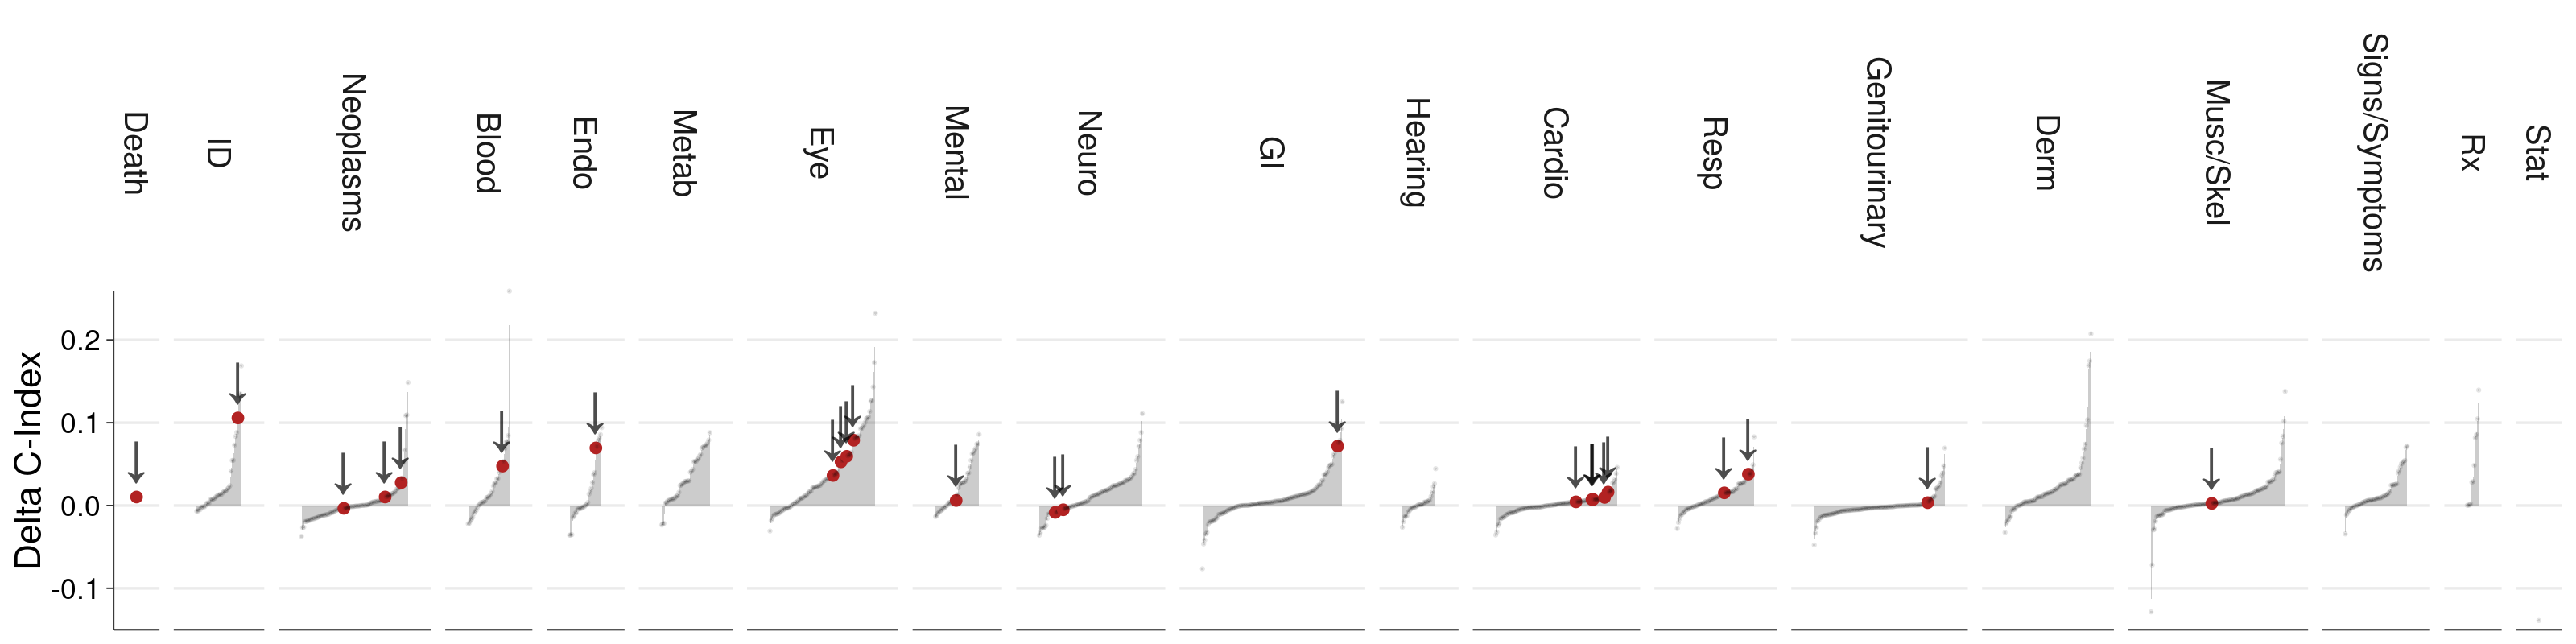

In [24]:
geom.text.size = 1

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp %>% arrange(delta))$endpoint

temp = temp %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) %>% mutate(endpoint = row_number())

ggplot(temp) +
    geom_ribbon(aes(x=endpoint, ymin=0, ymax=delta), fill="black", alpha=0.2)+
    geom_point(aes(x=endpoint, y=delta, color=highlight, size=highlight, alpha=highlight)) +
    geom_text(data=temp %>% filter(highlight=="YES"), aes(x=endpoint, y=delta+0.045, label="↓"), color="black", size=5, alpha=0.7) +
#     geom_text(data=tmp,
#               mapping = aes(x = -Inf, y = -Inf, label =s),
#               hjust   = -0.1, 
#               vjust   = -13) + 
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    labs(x="Endpoints", y=glue("Delta C-Index"))+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    scale_alpha_manual(values=c("NO"=0.1, "YES"=1))+
    scale_size_manual(values=c("NO"=0.01, "YES"=1))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    #coord_polar() +
    coord_cartesian(ylim=c(-0.15, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=20))+
    facet_grid(~phecode_category, scales="free_x", space="free_x")+#, switch=TRUE)+
    #facet_grid2(~phecode_category, scales = "free", independent = "all") + 
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major=element_blank(), 
         strip.text = element_text(angle=270)) + 
    theme(legend.position="none") 
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

## delta c-idx with positive values (negative set to 0)

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can
override using the `.groups` argument.


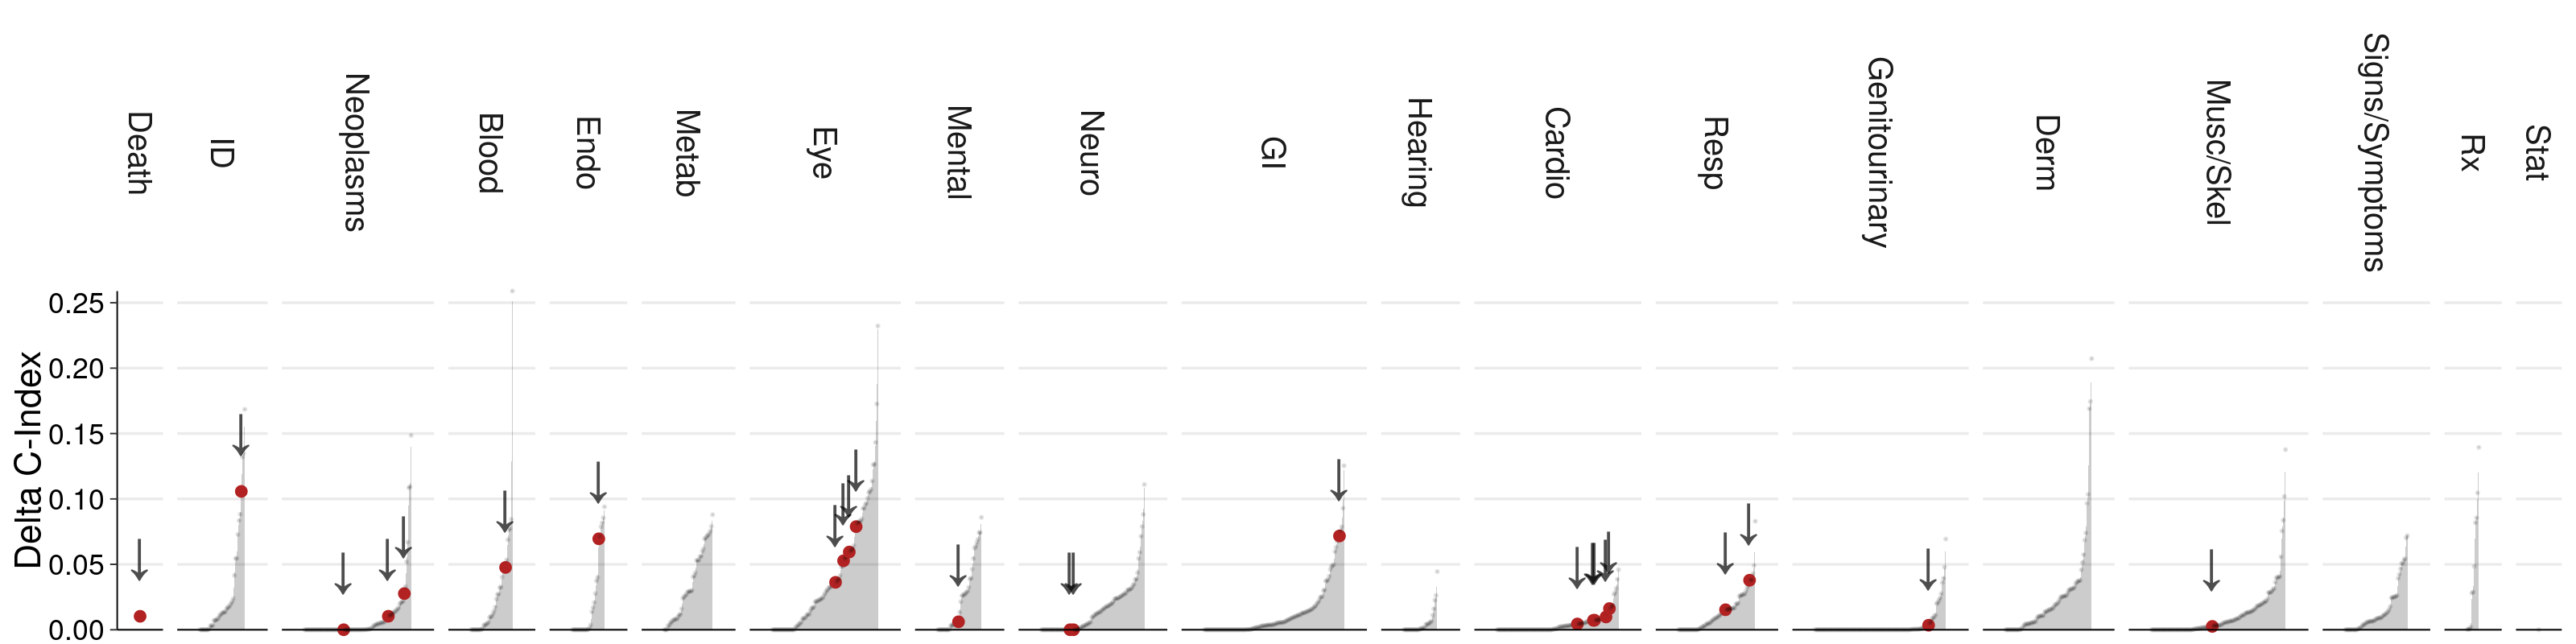

In [25]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp_pos = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`)

index <- temp_pos$delta < 0
temp_pos$delta[index] <- 0.

temp_pos = temp_pos %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp_pos %>% arrange(delta))$endpoint

temp_pos = temp_pos %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) %>% mutate(endpoint = row_number())

fig3a = ggplot(temp_pos) +
    geom_ribbon(aes(x=endpoint, ymin=0, ymax=delta), fill="black", alpha=0.2)+
    geom_point(aes(x=endpoint, y=delta, color=highlight, size=highlight, alpha=highlight)) +
    geom_text(data=temp_pos %>% filter(highlight=="YES"), aes(x=endpoint, y=delta+0.045, label="↓"), color="black", size=5, alpha=0.7) +
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    labs(x="Endpoints", y=glue("Delta C-Index"))+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    scale_alpha_manual(values=c("NO"=0.1, "YES"=1))+
    scale_size_manual(values=c("NO"=0.01, "YES"=1))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    #coord_polar() +
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=20))+
    facet_grid(~phecode_category, scales="free_x", space="free_x")+#, switch=TRUE)+
    #facet_grid2(~phecode_category, scales = "free", independent = "all") + 
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major=element_blank(), 
         strip.text = element_text(angle=270)) + 
    theme(legend.position="none") 
    
fig3a    
#geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

In [26]:
plot_name = "FIGURE3A_Cidx_Overview"
fig3a %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)
fig3a %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '↓' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '↓' in 'mbcsToSbcs': dot substituted for <86>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '↓' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '↓' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '↓' in 'mbcsToSbcs': dot substituted for <86>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '↓' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label

In [27]:
plot_width = 8.25; plot_height=2; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Retina", "Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #mutate(delta_int = `Age+Sex+Retina`-`Age+Sex+Retina`) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%
    filter(endpoint %in% endpoint_selection)
    #%>%
    #summarise(cindex = mean(cindex)) 
temp %>% head()

endpoint,model,iteration,time,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name,Age+Sex,Retina,Age+Sex+Retina,id,delta,pos,highlight
<fct>,<chr>,<int>,<int>,<chr>,<chr>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
OMOP_4306655,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.7057665,0.7097068,0.7177864,1,0.012019906,pos,YES
phecode_059-1,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,059.1,COVID-19*,ID,Both,1,059,1,COVID-19*,0.4731682,0.6133801,0.6376311,24,0.164462909,pos,YES
phecode_101,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,101,Malignant neoplasm of the digestive organs,Neoplasms,Both,0,101,0,Malignant neoplasm of the digestive organs,0.6780026,0.6639310,0.6744717,43,-0.003530869,neg,YES
phecode_102,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,102,Malignant neoplasm of the thoracic and respiratory organs,Neoplasms,Both,0,102,0,Malignant neoplasm of the thoracic and respiratory organs,0.6678604,0.6987773,0.6993121,51,0.031451663,pos,YES
phecode_103,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,103,Malignant neoplasm of the skin,Neoplasms,Both,0,103,0,Malignant neoplasm of the skin,0.6520279,0.6418123,0.6607757,53,0.008747737,pos,YES
phecode_164,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,164,Anemia,Blood,Both,0,164,0,Anemia,0.5832259,0.6300988,0.6310252,140,0.047799302,pos,YES


In [28]:
library(ggdist)

In [29]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

In [30]:
endpoint_selection 

[1] "phecode_202"    "phecode_401"    "phecode_404"    "phecode_404-1" 
 [5] "phecode_431-11" "phecode_424"    "phecode_059-1"  "phecode_468"   
 [9] "phecode_474"    "phecode_286-2"  "phecode_324-11" "phecode_328"   
[13] "phecode_164"    "phecode_726-1"  "phecode_371"    "phecode_374-42"
[17] "phecode_374-5"  "phecode_375-1"  "phecode_103"    "phecode_101"   
[21] "phecode_102"    "phecode_583"    "phecode_542"    "OMOP_4306655"

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



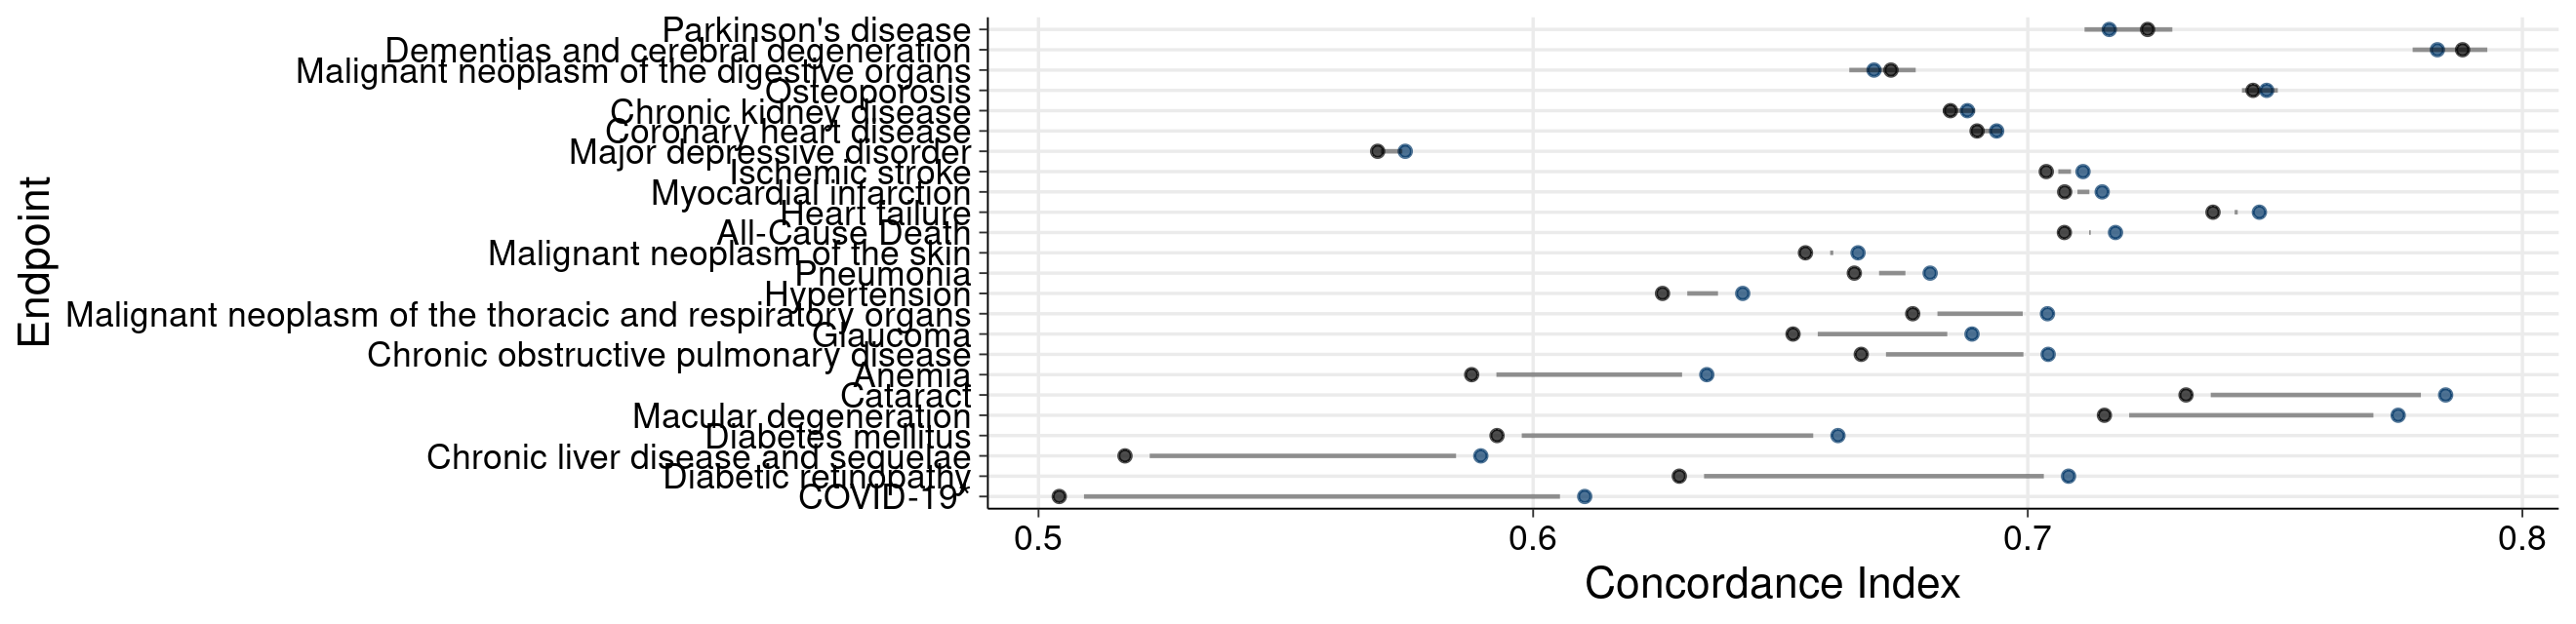

In [31]:
# temp %>% filter(endpoint %in% endpoint_selection) %>%
#     group_by(endpoint) %>%
#     summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`)) %>%
#     mutate(endpoint, recode_factor(endpoint, !!!endpoint_map))

abs = ggplot(temp %>% 
             filter(endpoint %in% endpoint_selection) %>%
             group_by(endpoint) %>%
             summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`))
                ) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Concordance Index", x="Endpoint")+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex`), size=1, color="black", alpha=0.3)+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex+Retina`), size=1, color="#023768", alpha=0.5)+
    geom_point(aes(x=fct_rev(endpoint), y=m_as), size=1, color="black", alpha=0.7)+
    geom_point(aes(x=fct_rev(endpoint), y=m_asm), size=1, color="#023768", alpha=0.7)+
    geom_segment(aes(x=endpoint, xend=endpoint, y=m_as+0.005, yend=m_asm-0.005), alpha=0.4)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_x_discrete(labels=endpoint_map) +
    #scale_x_discrete(labels=function(endpoint_map) formatC(endpoint_map, width=5)) +
    #scale_y_continuous(expand=c(0, 0))+
    #theme(axis.title.x=element_blank(),
     #   axis.text.x=element_blank(),
      #  axis.ticks.x=element_blank(),
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)
abs 

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



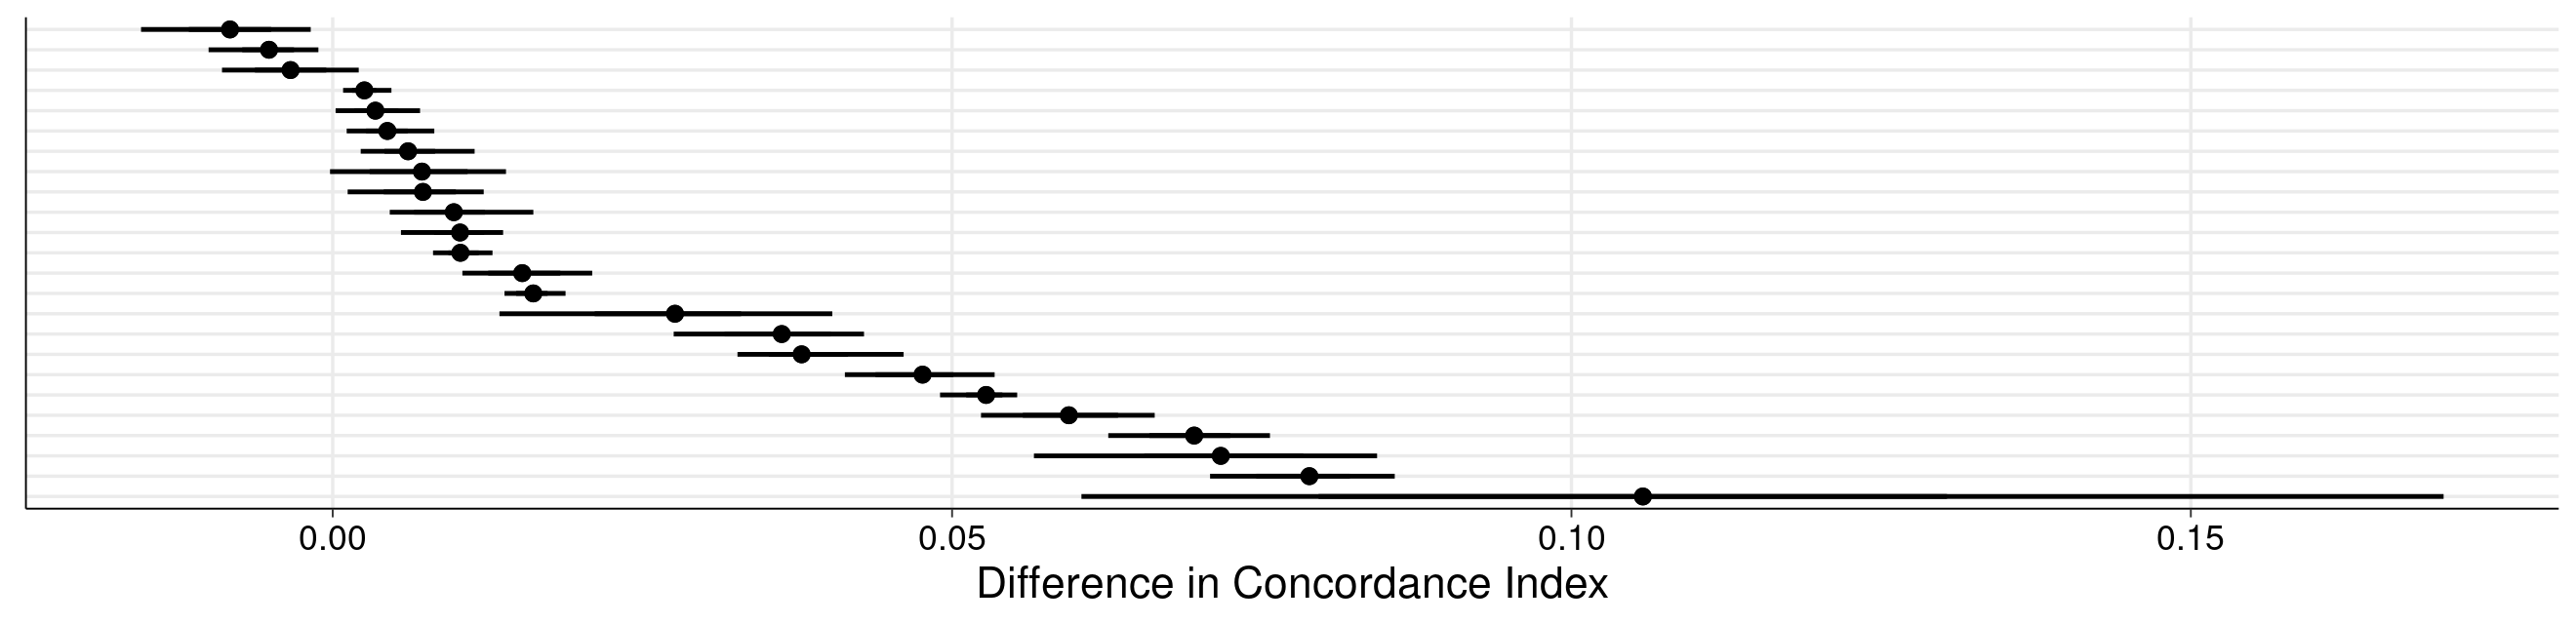

In [32]:
rel = ggplot(temp) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Difference in Concordance Index")+
    stat_pointinterval(aes(x=fct_rev(endpoint), y=delta), size=0.5)+
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    #scale_y_continuous(expand=c(0, 0))+
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
       axis.ticks.y=element_blank()) + 
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
rel    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

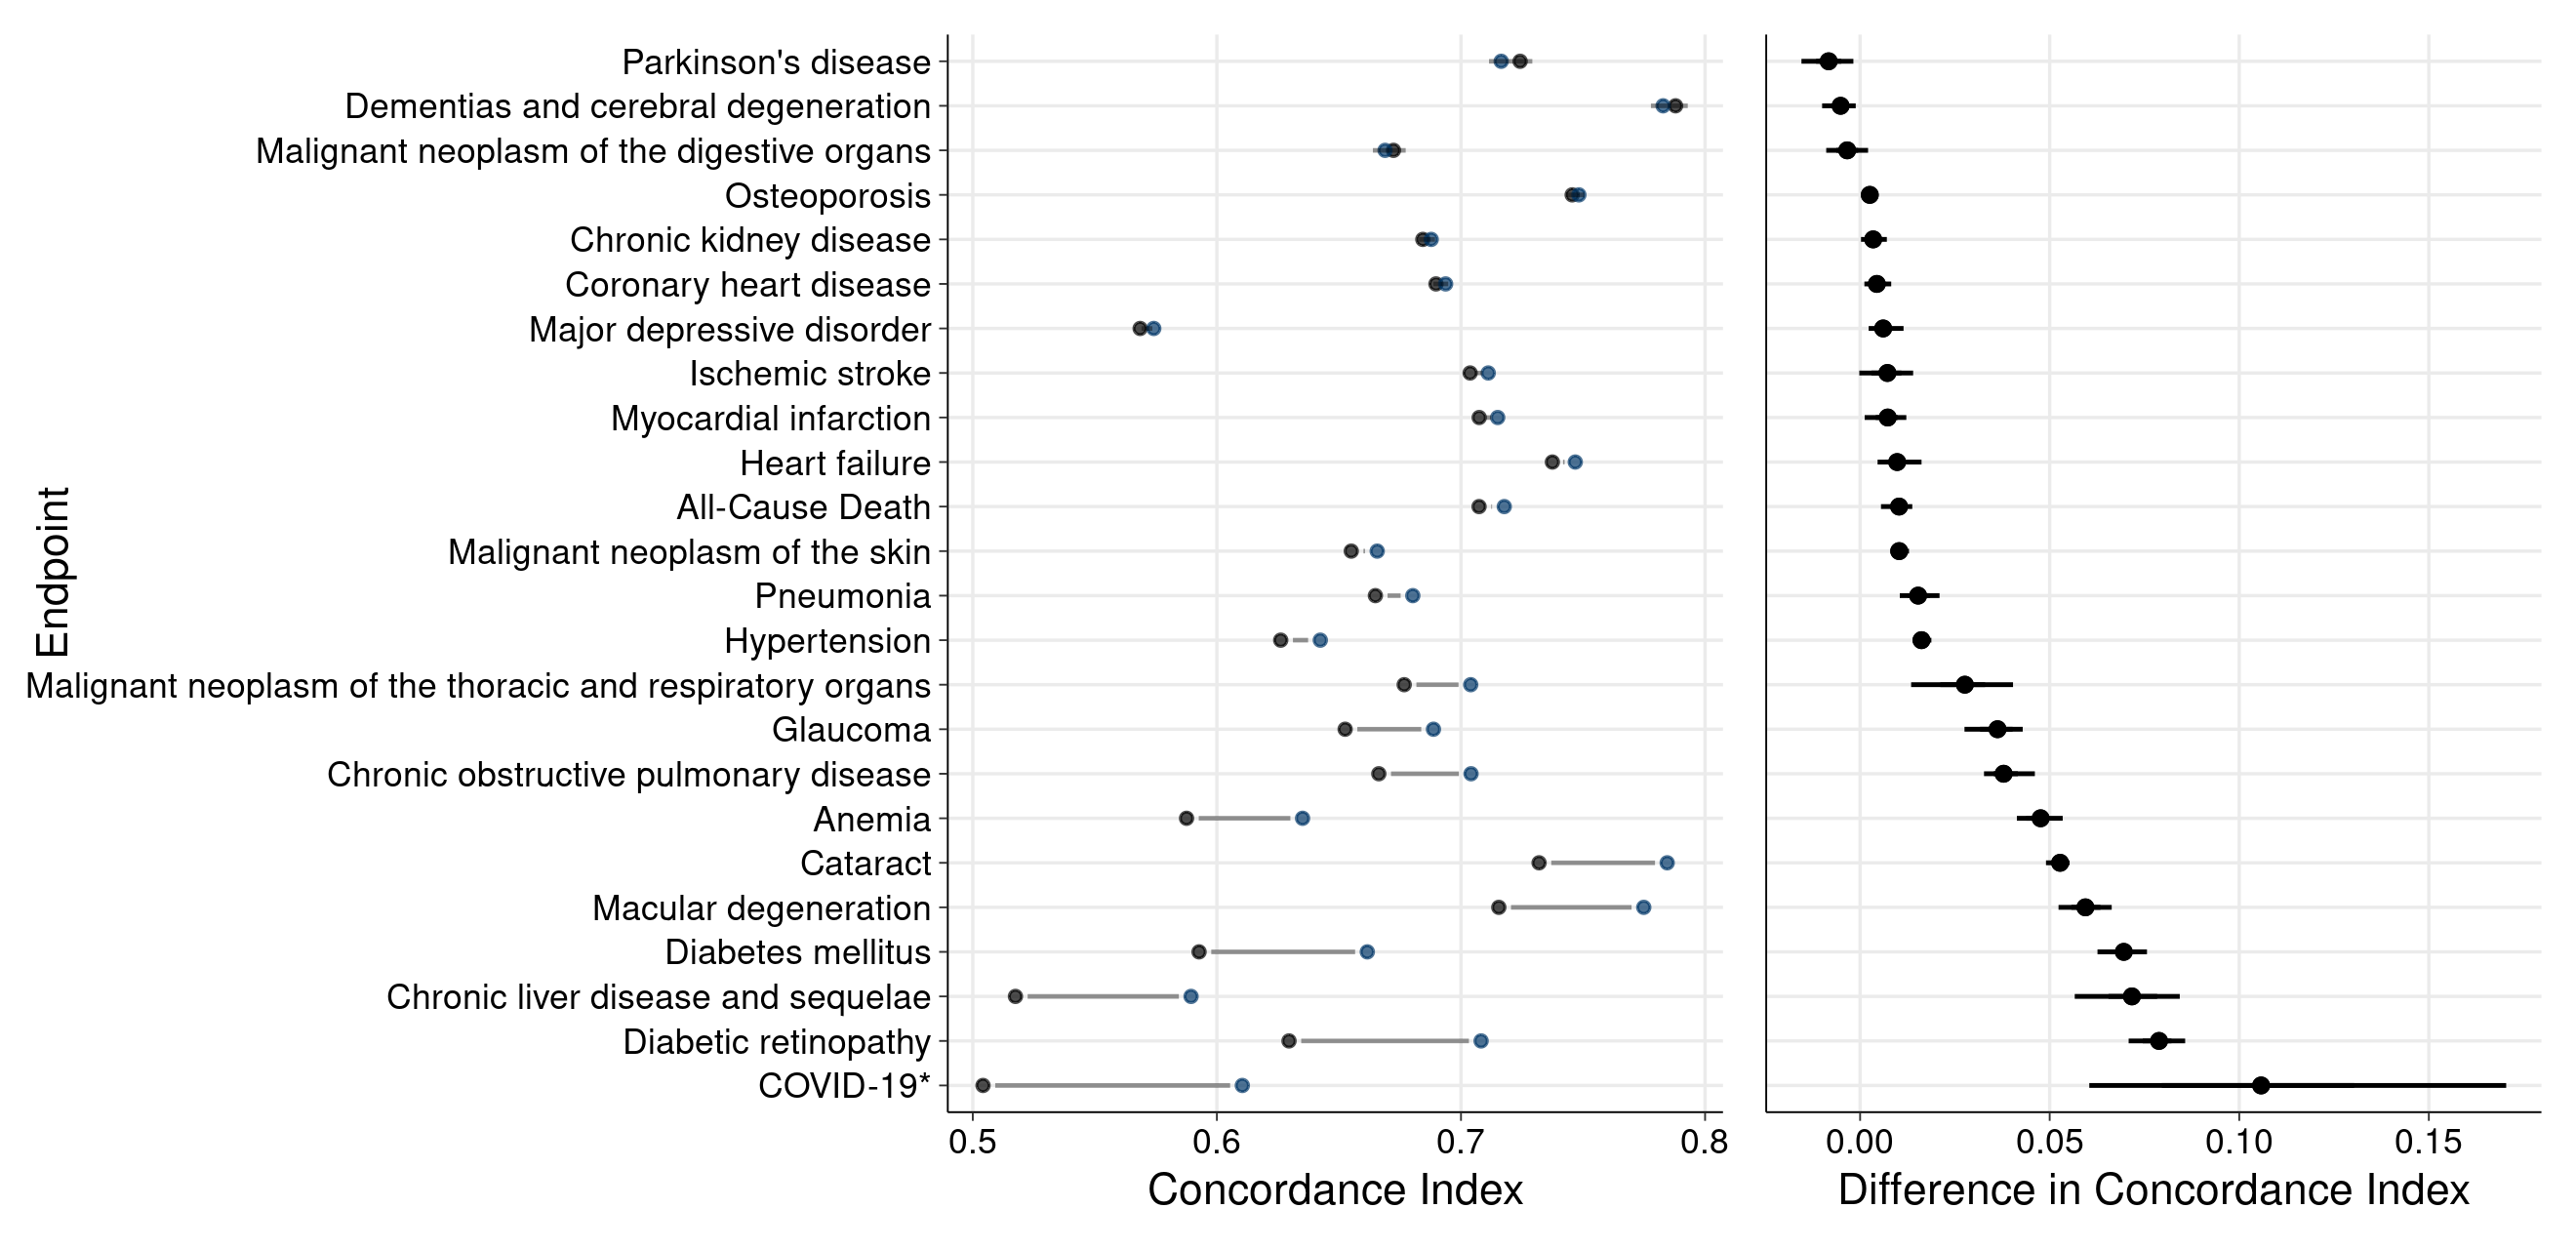

In [33]:
plot_width = 8.25; plot_height=4; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
fig3b = abs|rel

fig3b

In [34]:
plot_name = "FIGURE3B_Cidx_DELTAS"
fig3b %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)
fig3b %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

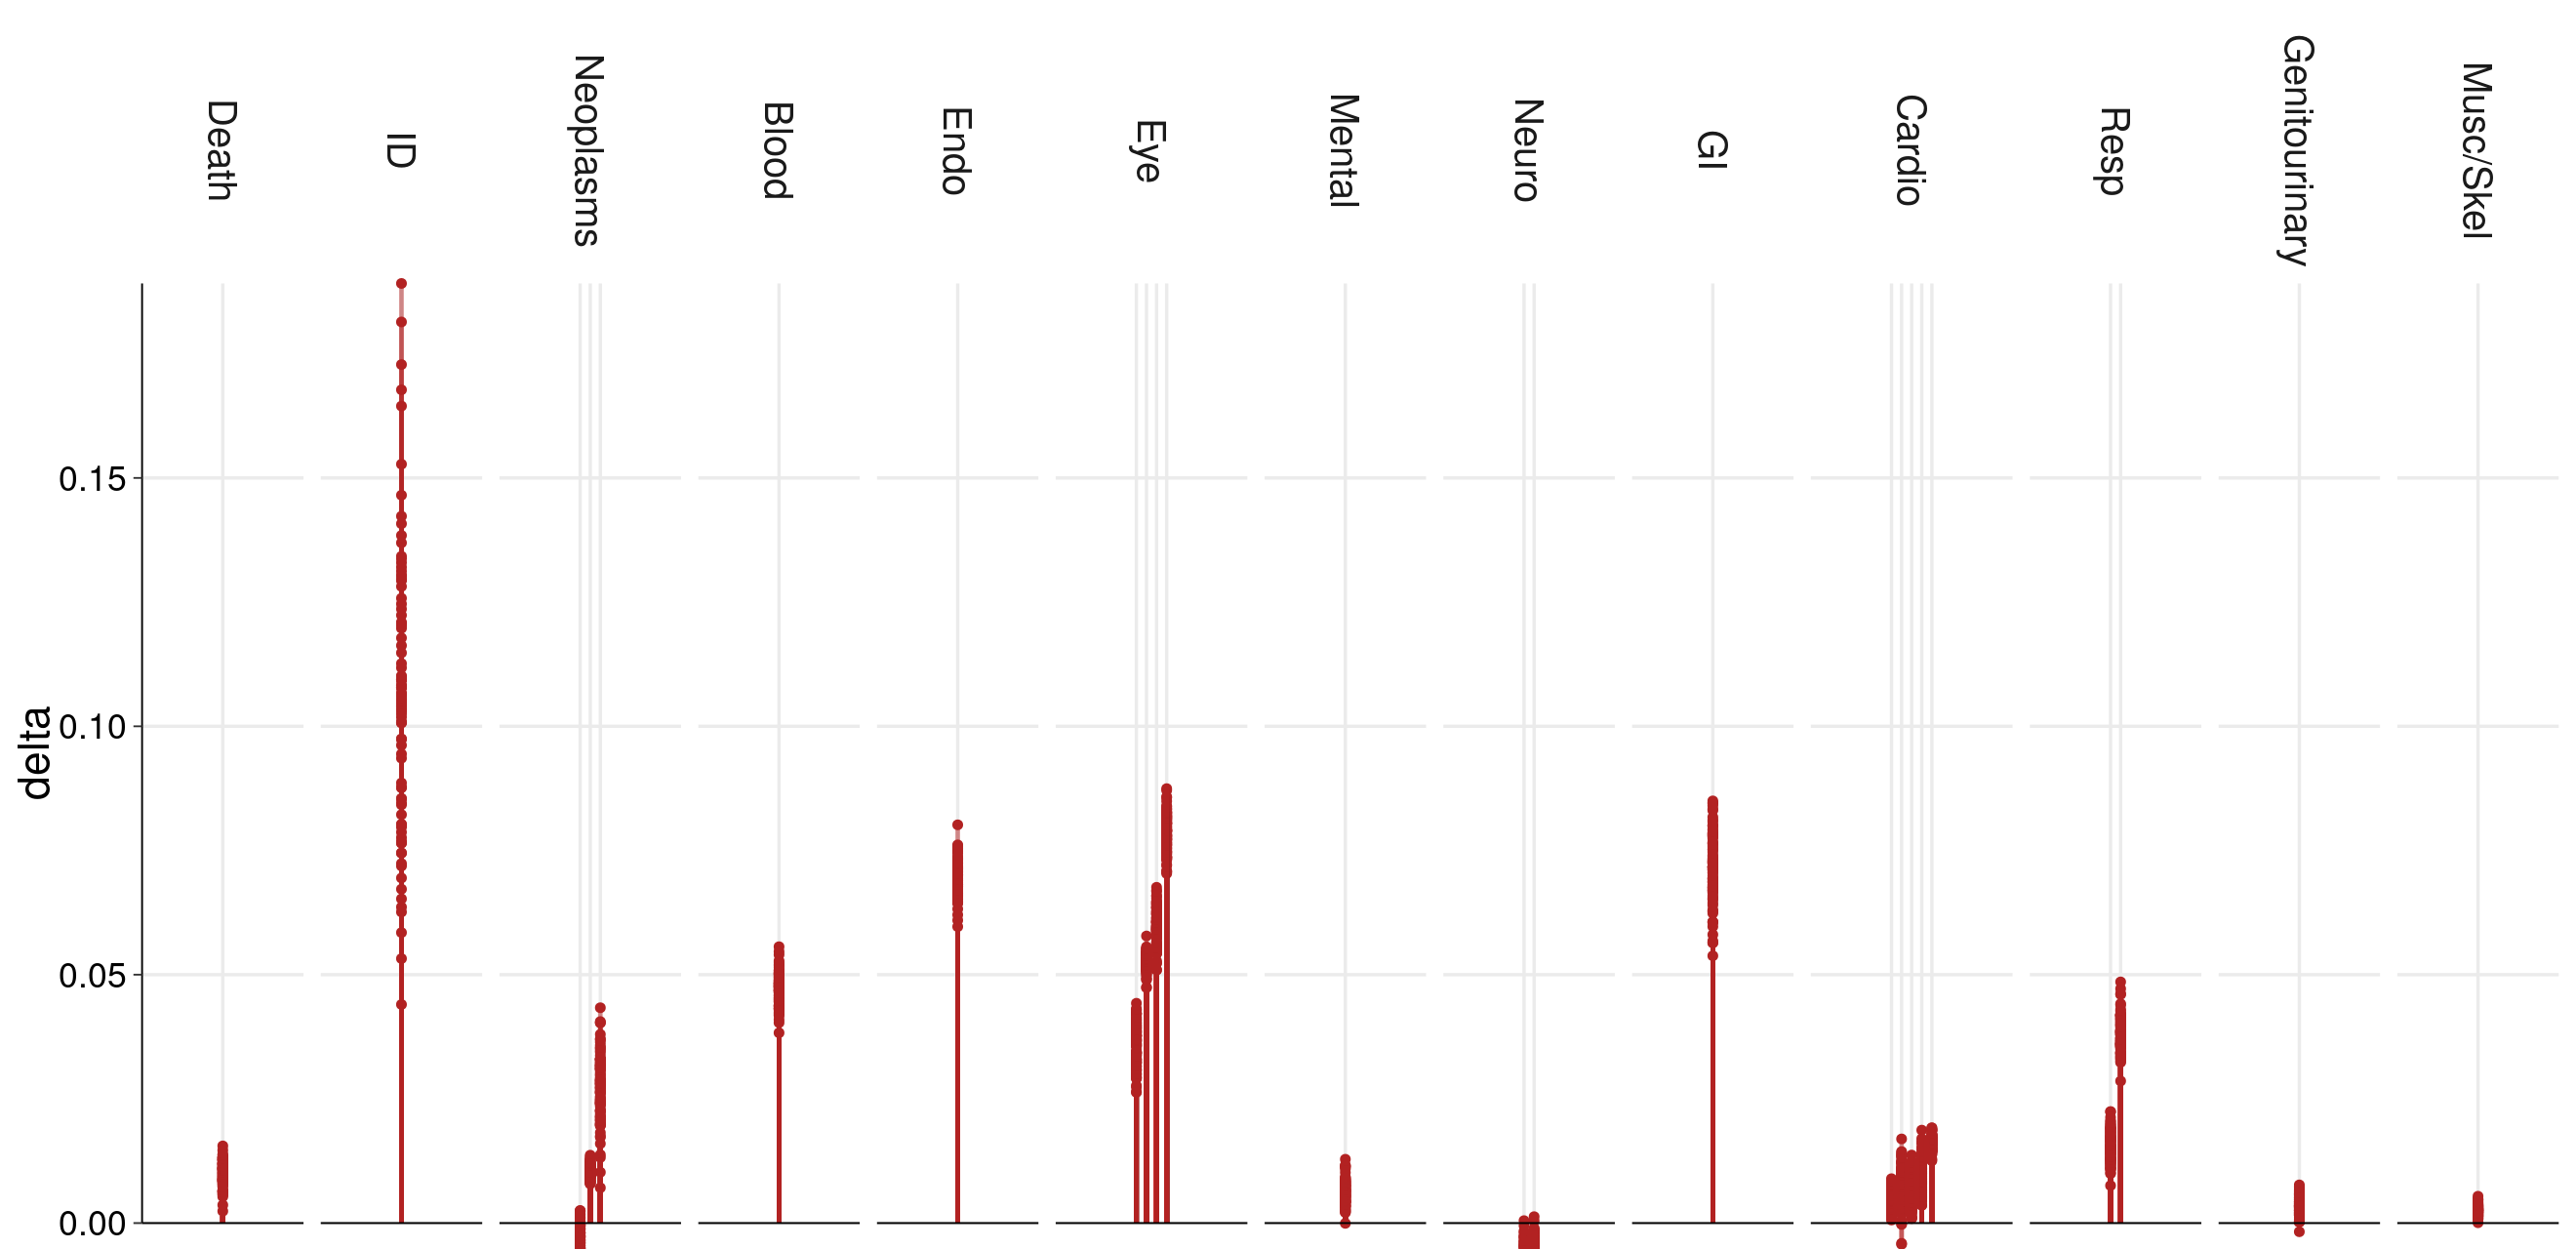

In [35]:
ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")

    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

In [36]:
table_2 = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+Retina`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>%
    #ungroup() %>%
    mutate(agg = glue("{round(cindex, 3)} ({round(.lower, 3)}, {round(.upper, 3)})")) %>%
    ungroup() %>% select(endpoint, phecode_string, phecode_category, type, agg) %>%
    pivot_wider(names_from=type, values_from=agg)
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    #mutate(endpoint = fct_reorder(endpoint, delta))# %>% filter(endpoint %in% endpoint_sample)

In [37]:
table_2 %>% 
    select(all_of(c("endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint)

endpoint,phecode_string,Age+Sex,Age+Sex+Retina,delta
<fct>,<chr>,<glue>,<glue>,<glue>
phecode_101,Malignant neoplasm of the digestive organs,"0.672 (0.663, 0.683)","0.669 (0.659, 0.68)","-0.003 (-0.009, 0.002)"
phecode_324-11,Parkinson's disease (Primary),"0.724 (0.709, 0.74)","0.716 (0.698, 0.731)","-0.008 (-0.015, -0.002)"
phecode_328,Dementias and cerebral degeneration,"0.788 (0.776, 0.802)","0.783 (0.772, 0.796)","-0.005 (-0.01, -0.001)"
phecode_726-1,Osteoporosis,"0.746 (0.74, 0.753)","0.748 (0.743, 0.755)","0.003 (0.001, 0.005)"
phecode_583,Chronic kidney disease,"0.684 (0.677, 0.692)","0.688 (0.681, 0.693)","0.003 (0, 0.007)"
phecode_404,Ischemic heart disease,"0.69 (0.683, 0.695)","0.694 (0.687, 0.699)","0.004 (0.001, 0.008)"
phecode_286-2,Major depressive disorder,"0.569 (0.562, 0.574)","0.574 (0.569, 0.581)","0.006 (0.002, 0.011)"
phecode_431-11,Cerebral infarction [Ischemic stroke],"0.704 (0.692, 0.715)","0.711 (0.7, 0.721)","0.007 (0, 0.014)"
phecode_404-1,Myocardial infarction [Heart attack],"0.707 (0.699, 0.715)","0.715 (0.707, 0.723)","0.007 (0.001, 0.012)"


In [38]:
options(pillar.print_max = Inf)
table_2 %>% 
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    #filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    mutate_if(is.numeric, round, 3) %>%
    write_csv(glue("outputs/SupplTable1_DiscriminativePerformanceAll_CropRatio-{crop_ratio}.csv"))

In [39]:
options(pillar.print_max = Inf)
table_2 %>% 
    arrange(as.character(endpoint)) %>%
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    mutate_if(is.numeric, round, 3) %>%
    write_csv(glue("outputs/SupplTable1_DiscriminativePerformanceEndpointSelection_CropRatio-{crop_ratio}.csv"))

# SOME QC -> where do the NaNs come from?

In [40]:
benchmark_endpoints %>% head()

endpoint,score,model,iteration,time,cindex,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name
<glue>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
OMOP_4306655,Age+Sex,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,0.7057665,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,0.7097068,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Age+Sex+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,0.7177864,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
phecode_002,Age+Sex,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,0.6102128,002,Staphylococcus,ID,Both,0,002,0,Staphylococcus
phecode_002,Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,0.6425846,002,Staphylococcus,ID,Both,0,002,0,Staphylococcus
phecode_002,Age+Sex+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,81,10,0.6203326,002,Staphylococcus,ID,Both,0,002,0,Staphylococcus


In [41]:
tmp = benchmark_endpoints %>% select(endpoint, phecode_string, iteration, cindex)
tmp[!complete.cases(tmp),]

endpoint,phecode_string,iteration,cindex
<glue>,<chr>,<int>,<dbl>


In [42]:
tmp %>% select(phecode_string) %>% count()

n
<int>
351300
